# Computing logical error rates with qLDPC and CUDA-Q

### Background

Recent advancements in quantum computing hardware and software have brought us closer to realizing fault-tolerant quantum computing.  The focus has shifted from simply increasing the number of physical qubits to prioritizing the development of logical qubits.  Logical qubits are created by encoding information into physical qubits with redundancy that allows physical errors to be diagnosed without revealing the encoded information.  Quantum error correcting (QEC) codes provide the framework for this encoding.

The surface code is the most widely studied QEC code, employing a square grid of physical qubits that require only nearest-neighbor connectivity.  Its appeal lies in its simplicity, compatibility with solid-state hardware platforms, and favorable thresholds for fault tolerance.  However, the surface code has large physical overheads, requiring upwards of one thousand physical qubits (or more) per logical qubit, thereby posing challenges for large-scale quantum computation.

Quantum low-density parity-check (QLDPC) codes, which includes the surface code as a special case, offer promising alternatives to the surface code.  These codes, inspired by their classical counterparts, are characterized by sparse parity-check matrices.  Specifically, as the size of a QLDPC code increases, the number of checks acting on each qubit and the number of qubits involved in each check remain bounded by a constant.  This structure limits the spread of errors in the code, which is critical for its fault-tolerant implementation.  QLDPC codes stand out for their ability to achieve high error-correction performance with low overhead, making them well-suited for emerging quantum architectures.

The [`qLDPC` library](https://github.com/Infleqtion/qLDPC) is a toolkit for users to explore, discover, and analyze QLDPC codes.  It is an active, open source repository attempting to advance knowledge of these codes and foster collaborative development of tools for their study and application.

### Installing and importing packages

In this notebook, we outline how one can use qLDPC in collaboration with NVIDIA's CUDA-Q QEC library to generate and study quantum error correcting codes.  Specifically, we show how one can identify pseudothreshold for the bivariate bicycle codes (BBCodes) in a code-capacity noise model.

We start by installing the latest versions of the qLDPC and CUDA-Q QEC libraries.

We start by installing the latest versions of the qLDPC and CUDA-Q QEC libraries

In [1]:
!pip install -qqq qldpc cudaq-qec

In [2]:
from typing import Sequence

import cudaq_qec as qec
import matplotlib.pyplot as plt
import numpy as np
import pymatching

import qldpc
from qldpc.codes import SurfaceCode
from qldpc.objects import Pauli

### The surface code

We first instantiate a SurfaceCode object with qLDPC. The surface code and other QEC codes can be found in the `codes` module of qLDPC.

We can instantiate a SurfaceCode by specifying its code distance.  Once instantiated, we query the object for various attributes.

In [3]:
surface_code = SurfaceCode(3)
ops_x = surface_code.get_logical_ops(Pauli.X)
ops_z = surface_code.get_logical_ops(Pauli.Z)

print("Surface code parameters:", surface_code.get_code_params())  # [n, k, d] ~ [physical qubits, logical qubits, code distance]
print(surface_code)
print()
print("logical X-type ops:", ops_x)
print()
print("logical Z-type ops:", ops_z)

Surface Code Parameters: (9, 1, 3)
SurfaceCode on 9 qubits
X-type parity checks:
[[1 1 0 1 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 1 0 1 1]]
Z-type parity checks:
[[1 1 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1]]
logical X-type ops: [[0 0 0 0 0 0 1 1 1]]
logical Z-type ops: [[1 0 0 0 1 0 0 0 1]]


Using the qLDPC library, we can instantiate surface codes of various distances and study their performance on a code capacity noise model. The code capacity noise model is a theoretical framework used in quantum error correction to evaluate the performance of error-correcting codes in an idealized setting. Under this model, it is assumed that errors occur only on the data qubits and only during computation, while the syndrome measurement and decoding processes are considered error-free. This simplification isolates the inherent error-correction capability of a quantum code, allowing one to determine its maximum tolerable noise threshold, known as the code capacity threshold. The relative simplicity of this model makes it favorable for a basic demonstration of finding a code threshold.

In order to generate a logical error rate, however, we will need a decoder. This is where the CUDA-Q QEC library is extremely handy, as it offers a variety of decoder options that can be digested by the qLDPC library. We can define a custom CUDA-Q decoder and pass it into our code capacity function. For the surface code, we can use a Minimum Weight Perfect Matching (MWPM) decoder, which is extremely efficient.

In [4]:
@qec.decoder("my_decoder")
class CudaQDecoder:
    def __init__(self, parity_check_matrix):
        qec.Decoder.__init__(self, parity_check_matrix)
        self.mwpm = pymatching.Matching.from_check_matrix(parity_check_matrix)

    def decode(self, syndrome):
        return self.mwpm.decode(syndrome)

The below cell uses qLDPC and our CUDA-Q decoder to generate a logical error rate and plot it.

In [5]:
def make_figure(
    codes: Sequence[qldpc.codes.ClassicalCode | qldpc.codes.CSSCode],
    num_samples: int = 10**3,
    physical_rates: Sequence[float] = list(np.logspace(-4, -0.1, 100)),
    figsize: tuple[int, int] = (8, 6),
    **decoding_args: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Make a figure comparing physical vs. logical error rates in a code family."""
    figure, axis = plt.subplots(figsize=figsize)

    for code in codes:
        get_logical_error_rate = code.get_logical_error_rate_func(
            num_samples, max(physical_rates), **decoding_args
        )
        logical_rates, stderrs = get_logical_error_rate(physical_rates)
        bound = code.get_distance_bound(num_trials=10**3)
        line, *_ = axis.plot(
            physical_rates, logical_rates, label=f"[{code.num_qubits}, {code.dimension}, {bound}]"
        )
        axis.fill_between(
            physical_rates,
            logical_rates - stderrs,
            logical_rates + stderrs,
            color=line.get_color(),
            alpha=0.2,
        )

    axis.axline(
        [0, 0],
        slope=1,
        color="k",
        linestyle=":",
        label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
    )
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_xlim(right=1)
    axis.set_ylim(bottom=max(min(physical_rates) ** 2, axis.get_ylim()[0]), top=1)
    axis.set_xlabel(r"physical error rate $p_{\mathrm{phys}}$")
    axis.set_ylabel(r"logical error rate $p_{\mathrm{log}}$")
    axis.legend(loc="best")
    figure.tight_layout()
    return figure, axis

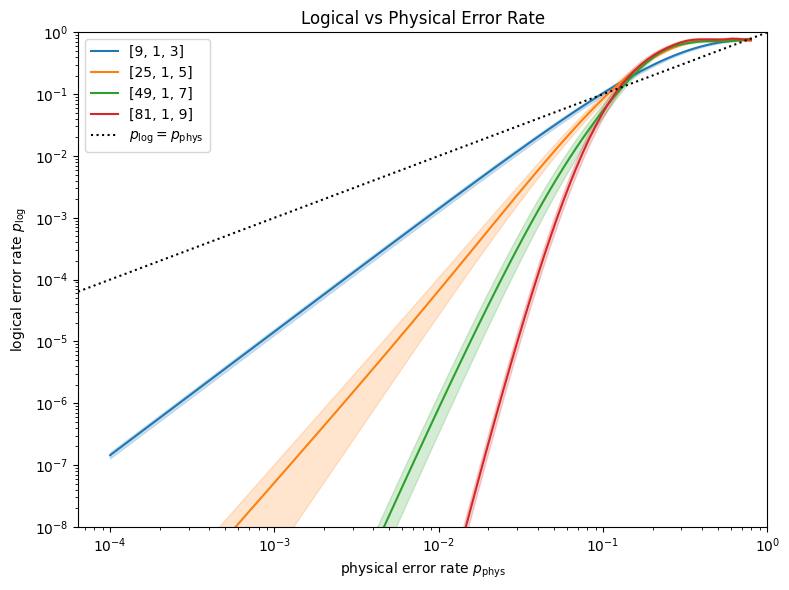

In [6]:
surface_codes = [SurfaceCode(dist) for dist in [3, 5, 7, 9]]
make_figure(surface_codes, decoder_constructor=CudaQDecoder)
plt.show()

Above, we see a plot of logical vs physical error rate for a various surface codes using a code capacity noise model. The code threshold seems to be close to the 10% mark. While this might seem quite high, remember that this isn't a circuit level investigation, but a code capacity noise model. In reality, there are many more sources of error in a quantum computer, and we would correspondingly see lower thresholds and higher logical error rates.

While the surface code is technically a QLDPC code, its encoding rate is relatively inefficient, making it impractical for solving large-scale problems that require thousands of logical qubits. In recent years, several papers have introduced QLDPC codes with significantly improved encoding rates, high thresholds, and more manageable hardware requirements. One such family of quantum error correction codes is the Bivariate Bicycle Code (BBCode), introduced by IBM in 2024 (https://arxiv.org/pdf/2308.07915). This code uses two polynomials, A and B, to define operations on shift matrices. The resulting matrices function as parity check matrices for the code and exhibit favorable encoding rates and thresholds, while requiring only a limited number of long-range qubit connections. BBCodes are seen as an extremely promising candidate for encoding logical qubits across most hardware modalities.

Like the surface code, we can find the Bivariate Bicycle Code family in the `qldpc.codes` module. In order to instantiate a `BBCode` object, we need to specify the polynomials used to generate the partiy check matrices of the code.

In [7]:
from sympy.abc import x, y

bb_codes = [
    qldpc.codes.BBCode(
        {x: 6, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
    qldpc.codes.BBCode(
        {x: 15, y: 3},
        x**9 + y + y**2,
        1 + x**2 + x**7,
    ),
    qldpc.codes.BBCode(
        {x: 9, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
    qldpc.codes.BBCode(
        {x: 12, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
    qldpc.codes.BBCode(
        {x: 12, y: 12},
        x**3 + y**2 + y**7,
        y**3 + x + x**2,
    ),
]

MWPM is specifically designed for pairwise matching problems, where the information from a pair of syndromes is sufficient to detect an error.  However, due to the increased complexity and connectivity demands of QLDPC codes like the BBCode, MWPM is not suitable for effective decoding.  Instead, a BP-OSD (Belief Propagation + Ordered Statistics Decoding) decoder can be used for this purpose.

In [2]:
@qec.decoder("my_decoder")
class CudaQDecoder:
    def __init__(self, H):
        qec.Decoder.__init__(self, parity_check_matrix)
        self.bposd = qldpc.decoders.get_decoder_BP_OSD(parity_check_matrix)

    def decode(self, syndrome):
        return self.bposd.decode(syndrome)

NameError: name 'qec' is not defined

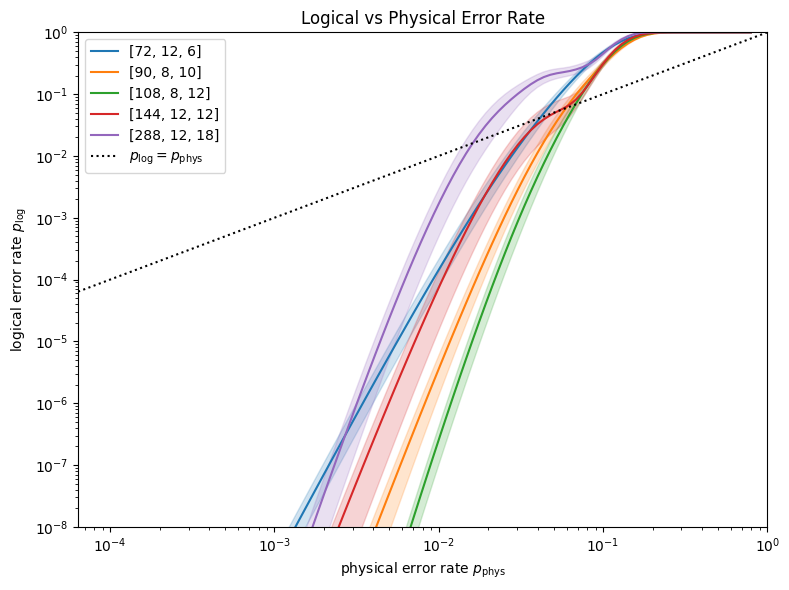

In [9]:
make_figure(bb_codes, decoder_constructor=CudaQDecoder)
plt.show()